In [1]:
import pandas as pd
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from math import sqrt

## Find your dataset

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We'll take a look at some data from https://www.baseball-reference.com/

In [3]:
# What's our current working directory?
home_plate=Path.cwd()
home_plate

PosixPath('/content')

In [4]:
# What's the path from there to our data folder?
dugout=Path.joinpath(home_plate.parent, 'data')
dugout

PosixPath('/data')

In [5]:
# What's in there?
for player in dugout.glob('*'):
    print(player.name)

## Exploratory Data Analysis

In [6]:
# Let's open the hitters dataset.
hitters_file = 'https://raw.git.generalassemb.ly/DCDAT35/10-linear-regression/master/linear-regression/data/hitters.csv?token=AAACG7CQNXDVGVV2SKFELS27LKYKG'
baseball = pd.read_csv(hitters_file)
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [7]:
# How large is the dataset?
baseball.shape

(322, 20)

In [8]:
# What are the variables?
baseball.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [9]:
# Is there any missing data?
baseball.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [10]:
# What variables are correlated with each other?
corrs=baseball.corr()
corrs

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.000000,0.967939,0.592198,0.913060,0.820539,0.669845,0.047372,0.235526,0.252717,0.236659,0.266534,0.244053,0.166123,0.317550,0.353824,0.352117,0.394771
Hits,0.967939,1.000000,0.562158,0.922187,0.811073,0.641211,0.044767,0.227565,0.255815,0.202712,0.261787,0.232005,0.151818,0.310673,0.320455,0.310038,0.438675
HmRun,0.592198,0.562158,1.000000,0.650988,0.855122,0.481014,0.116318,0.221882,0.220627,0.493227,0.262361,0.351979,0.233154,0.282923,-0.106329,0.039318,0.343028
Runs,0.913060,0.922187,0.650988,1.000000,0.798206,0.732213,0.004541,0.186497,0.204830,0.227913,0.250556,0.205976,0.182168,0.279347,0.220567,0.240475,0.419859
RBI,0.820539,0.811073,0.855122,0.798206,1.000000,0.615997,0.146168,0.294688,0.308201,0.441771,0.323285,0.393184,0.250914,0.343186,0.106591,0.193370,0.449457
Walks,0.669845,0.641211,0.481014,0.732213,0.615997,1.000000,0.136475,0.277175,0.280671,0.332473,0.338478,0.308631,0.424507,0.299515,0.149656,0.129382,0.443867
Years,0.047372,0.044767,0.116318,0.004541,0.146168,0.136475,1.000000,0.920289,0.903631,0.726872,0.882877,0.868812,0.838533,-0.004684,-0.080638,-0.162140,0.400657
CAtBat,0.235526,0.227565,0.221882,0.186497,0.294688,0.277175,0.920289,1.000000,0.995063,0.798836,0.983345,0.949219,0.906501,0.062283,0.002038,-0.066922,0.526135
CHits,0.252717,0.255815,0.220627,0.204830,0.308201,0.280671,0.903631,0.995063,1.000000,0.783306,0.984609,0.945141,0.890954,0.076547,-0.002523,-0.062756,0.548910
CHmRun,0.236659,0.202712,0.493227,0.227913,0.441771,0.332473,0.726872,0.798836,0.783306,1.000000,0.820243,0.929484,0.799983,0.112724,-0.158511,-0.138115,0.524931


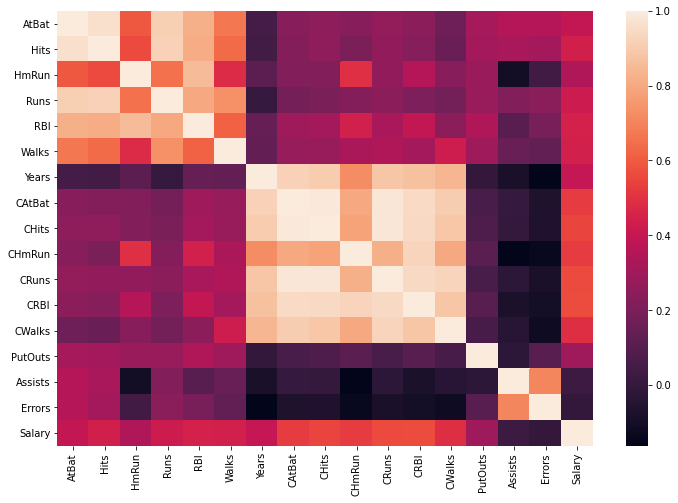

In [11]:
# Display all of that as a heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(corrs);

#### How do we interpret this heatmap?
There are two "light" squares:
* at-bats, hits, homeruns, RBIs, and walks
* Years and Career Stats(at-bats, hits, homeruns, RBIs, and walks)   

So let's build our model around one of those sets of variables, and focus on runs as our target outcome.

In [12]:
# What variables are most correlated with runs?
corrs['Runs'].sort_values(ascending=False)

Runs       1.000000
Hits       0.922187
AtBat      0.913060
RBI        0.798206
Walks      0.732213
HmRun      0.650988
Salary     0.419859
PutOuts    0.279347
CRuns      0.250556
Errors     0.240475
CHmRun     0.227913
Assists    0.220567
CRBI       0.205976
CHits      0.204830
CAtBat     0.186497
CWalks     0.182168
Years      0.004541
Name: Runs, dtype: float64

## Model Building

In [13]:
# Declare your target variable.
y = baseball['Runs']

In [14]:
# Declare your feature variables. 
X = baseball[['AtBat', 'Hits', 'HmRun', 'RBI', 'Walks']]

In [15]:
# Train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
# What do some of those values look like? Interpret these numbers.
y_test[:5]

173    17
132    22
197    20
9      49
104    67
Name: Runs, dtype: int64

In [17]:
# Instantiate the sklearn regression class; give it a name.
my_model = LinearRegression()

In [18]:
# Fit the model to your training dataset.
my_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# Predict the y-values on the testing set.
y_pred = my_model.predict(X_test)

In [20]:
# Take a look at the predictions for the first 5 players in the testing set.
[round (x,2) for x in y_pred[:5]]

[19.21, 30.44, 13.91, 55.1, 66.63]

In [21]:
# compare that to the actual runs of the first five players in the data.
list(y_test[:5])

[17, 22, 20, 49, 67]

## Evaluate the model

In [22]:
# On average, by how much value are we missing the mark?
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
print(f'On average, our model errs by {round(rmse)} runs per player.')

On average, our model errs by 7 runs per player.


In [23]:
# So... what if we just flipped a coin?
avg_val=round(y_train.mean())
print(f'The average is {avg_val} runs per player.')

The average is 50 runs per player.


In [24]:
# If we used that as our predictor, then the average error of our model would be:
comparison_array=np.full((len(y_test), ), avg_val)
coin_flip=sqrt(metrics.mean_squared_error(y_test, comparison_array))
print(round(coin_flip))

27


In [25]:
# So, is our model better than just taking the average number of runs?
print(f'improvement over mean prediction: {round(rmse-coin_flip)} runs')
# Remember, less error is a good thing!

improvement over mean prediction: -20 runs


In [26]:
# A higher R2 score indicates more variance explained.
r2=metrics.r2_score(y_test, y_pred)
round(r2,2)

0.93

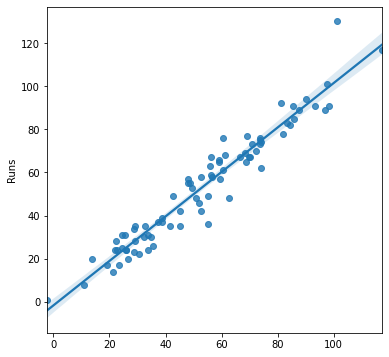

In [27]:
# Let's display our predictions vs. real values.
plt.figure(figsize=(6, 6))
sns.regplot(x=y_pred, y=y_test);

## Examine an individual prediction

#### Let's look at the very first player

In [28]:
# Who's the first player in the testing dataset?
X_test.head()

,AtBat,Hits,HmRun,RBI,Walks
173,161,43,4,26,22
132,278,70,7,37,18
197,166,34,0,13,17
9,401,92,17,66,65
104,397,114,23,67,53


In [29]:
# Let's take a look stats for player #173.
X_test.loc[173]

AtBat    161
Hits      43
HmRun      4
RBI       26
Walks     22
Name: 173, dtype: int64

In [30]:
# How many runs did he actually get?
y_test.loc[173]

17

In [31]:
# Let's convert his stats into a numpy array with the appropriate shape.
row=np.array(X_test.loc[173].values)
row_reshaped=row.reshape(1, 5)
row_reshaped

array([[161,  43,   4,  26,  22]])

In [32]:
# How many runs does our model predict that he would get?
my_model.predict(row_reshaped)

array([19.20841314])

In [33]:
# We can also just get that by calling the first element of our list of predictions, from earlier.
y_pred[0]

19.208413143919266

In [34]:
# If we had just taken the average of all players, how many runs would we have predicted for him?
round(y_train.mean())

50

## Make predictions on new data.

#### Let's pretend the year is 1956.
Mickey Mantle is playing first base. How many hits do we predict he'll get?   
https://www.baseball-reference.com/players/m/mantlmi01.shtml  


In [35]:
# Here are his actual stats.
Runs=132
AtBat=533
Hits=188
HmRun=52
RBI=130
Walks=112
# http://www.highheatstats.com/2013/01/taking-a-look-at-mickey-mantles-1956/

In [36]:
# We need to reshape the data into a 2D numpy array
row=np.array([AtBat, Hits, HmRun, RBI, Walks])
row_reshaped=row.reshape(1, 5)
row_reshaped

array([[533, 188,  52, 130, 112]])

In [37]:
# Let's make a prediction based on those stats.
prediction=my_model.predict(row_reshaped)
round(prediction[0])

125.0

In [38]:
# What's the error in our model, for Mickey Mantle?
error = prediction[0]-Runs
round(error)

-7.0

Ted Williams of the Red Sox finished sixth in MVP voting that year, and had an even higher on base percentage (.479) than Mantle. Let's see how our model does with his 1956 stats.

In [39]:
# https://www.baseball-reference.com/players/w/willite01.shtml
Runs=71
AtBat=400
Hits=138
HmRun=24
RBI=82
Walks=102

In [40]:
# We need to reshape the data into a 2D numpy array
row=np.array([AtBat, Hits, HmRun, RBI, Walks])
row_reshaped=row.reshape(1, 5)
row_reshaped

array([[400, 138,  24,  82, 102]])

In [41]:
# Let's make a prediction based on those stats.
prediction=my_model.predict(row_reshaped)
round(prediction[0])

87.0

In [42]:
# What's the error in our model, for Ted Williams?
error = prediction[0]-Runs
round(error)

16.0

## Now it's your turn.

Try to build your own linear regression model, but using _career_ stats instead of _year_ stats.